In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

## Prepare Data 


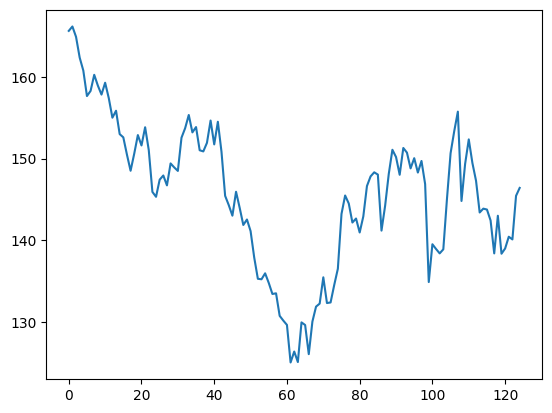

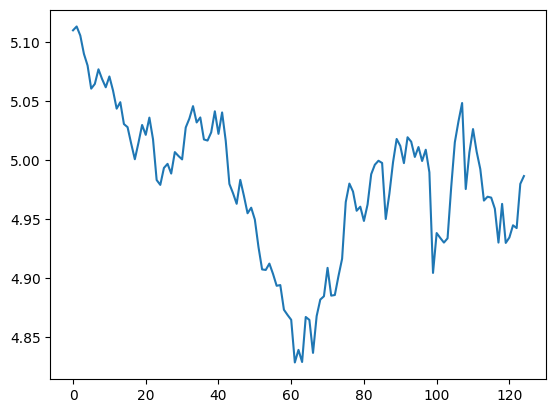

In [51]:
#Load in data
df = pd.read_csv(r'C:\Users\Owner\Downloads\HistoricalData_1680742963381.csv', parse_dates=['Date'])

plt.plot(df['Close/Last'])
plt.show()

df['log'] = np.log(df["Close/Last"])
timeseries = df[["log"]].values.astype('float32')

plt.plot(timeseries)
plt.show()

### Plot ACF and PACF

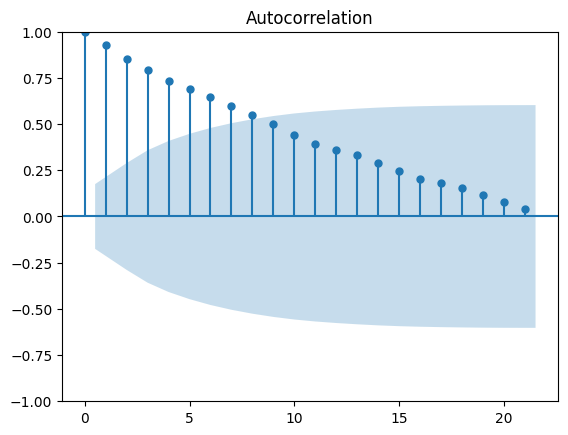

In [13]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(df["Close/Last"])
plt.show()

### Create Log-Diff of Bitcoin Price

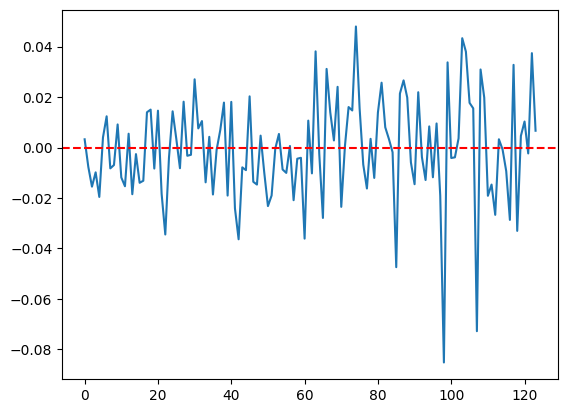

In [52]:
#1st difference of ts to create stationary data
diff = []
for i in range(1, len(timeseries)):
 value = timeseries[i] - timeseries[i - 1]
 diff.append(value)

plt.plot(diff)
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

### Train-Test Split

In [36]:
# train-test split for time series
train_size = int(len(diff) * 0.67)
test_size = len(diff) - train_size
train, test = diff[:train_size], diff[train_size:]

print(len(train))
print(len(test))

83
41


### Create tensor dataset

In [81]:
def create_dataset1(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        inputs = dataset[i:i+lookback]
        labels = dataset[i+1:i+lookback+1]
        X.append(inputs)
        y.append(labels)
    return torch.tensor(X), torch.tensor(y)
 
lookback = 10
X_train, y_train = create_dataset1(train, lookback=lookback)
X_test, y_test = create_dataset1(test, lookback=lookback)

## LSTM Class


In [70]:
class LSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=42, num_layers=1, batch_first=True)
        self.linear = nn.Linear(42, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

## Training


In [ ]:
model = LSTM()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=False, batch_size=10)
 
n_epochs = 2000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

## Plotting Results of LSTM



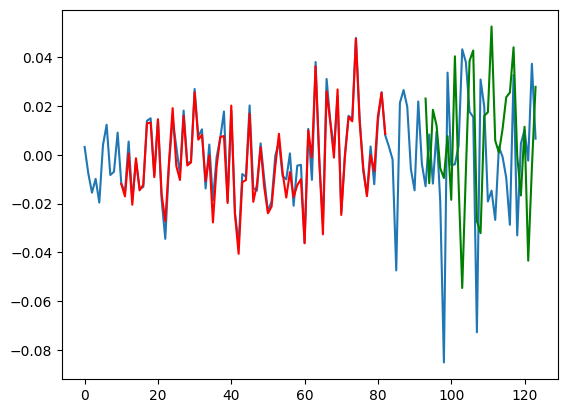

In [79]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(diff) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(diff) * np.nan
    test_plot[train_size+lookback:len(diff)] = model(X_test)[:, -1, :]
# plot
plt.plot(diff)
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()